# Table of content<a id='toc'></a>

0) [Abstract](#abstract)
1) [Image preprocessing]:(#preprocessing)
    - [Converting data from DCM files to PNG images.](#convert)
    - Windowing.
    - [Cropping out region of interest (RoI).](#roi)
    - [Resize images.](#resize)
2) [Preparing data for use in Torch.](#data_preparation)
    - [Train test split.](#train_test_split)
    - [Data augmentation](#augmentation)
    - [Divide images by class.](#class_separation)
4) [Uploading data to cloud storage.](#upload)
5) [Torch preparation block]:
    - Writing train and test loops.
    - Writing custom metric functions.
    - Creating datasets.
    - Implement transfer learning.
6) Train model.
7) Inference.
8) Conclusion.

# Abstract<a id='abstract'></a>

This notebook is based on RSNA Screening Mammography Breast Cancer Detection competition from Kaggle. My interest in data science and machine learning was initially sparked by medical applications, so I am excited to work on a project related to this field. The specific dataset I will be using comes from the aforementioned Kaggle competition. However, I will not be using the metric employed in the competition as my aim is not to participate but rather to address a problem of interest. Unlike the competition participants, I will focus on predicting the presence of cancer rather than its probability. It will be a binary classification problem with recall as the primary metric, though precision and F1 score will also be included as auxiliary metrics.

There is a CSV file containing patient data; however, I will not use it for making predictions this time. Instead, I aim to see if I can achieve acceptable results using only computer vision, despite the valuable information available. For instance, a brief exploratory data analysis (EDA) of the CSV file revealed that cancer is more common in older patients. Nevertheless, we want our model to make unbiased predictions based on tissue images alone and not consider age if some images have similar formations.


## Preprocessing<a id='preprocessing'></a>

In [1]:
%matplotlib inline
import os
import re
import glob
import shutil
from PIL import Image
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A #data augmentation
import pydicom # working with dcm files
from pydicom.pixel_data_handlers import apply_windowing
import cv2

Obtain a list of all DCM files and specify a directory to save PNG files to.

In [2]:
path_dicom = '../train_images/'
path_png = '../png/'
images_dicom = glob.glob(path_dicom+ '*/*.dcm')

Sequence of image transformation will appear as follows.

<img src='images/workflow.png'>

### Convert DCM to grayscale PNG and apply windowing.<a id='convert'></a>
[back to table of content](#toc)

DCM files are not merely images; they contain extensive metadata and look like this:

In [2]:
pydicom.dcmread('../train_images/5/640805896.dcm')

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.10009.1.2.3.5.1.640805896
(0002, 0010) Transfer Syntax UID                 UI: JPEG 2000 Image Compression (Lossless Only)
(0002, 0012) Implementation Class UID            UI: 1.2.840.113654.2.3.1995.2.12.0
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.840.10009.1.2.3.5.1.640805896
(0008, 0023) Content Date                        DA: '20221118'
(0008, 0033) Content Time                        TM: '184950.680341'
(0010, 0020) Patient ID                          LO: '5'
(0020, 000d) Study Instance UID                  UI: 1.2.840.10009.1.2.3.5
(0020, 000e) Series Instance UID              

We are focused on the Center and Width parameters, which are essential for windowing. Incorrect values can corrupt images rather than enhance them. This issue occurred with half of the patients examined on a machine with ID 21. I have been researching windowing and attempting to develop a windowing function myself; however, I have yet to find a solution that accommodates all the images. For the time being, we will forego windowing for these images until I can revisit the problem when time permits.

In [3]:
def convert_dcm_to_png_windowing(path_image: str, 
                                 dir_save_to: str='../png/') -> None:
    
    id_patient, id_img = re.findall('(\d+)', path_image)[-2:]
    path_save = os.path.join(dir_save_to, id_patient) 
    
    if os.path.isfile(os.path.join(path_save, id_img + '.png')):
        pass
    else:
            
        dicom = pydicom.dcmread(path_image)
        
        img = dicom.pixel_array
        
        #JPEG2000 images will turn completely black after windowing so we will skip them for now.
        # Not all images are significantlyaffected by windowing anyway.
        if dicom.file_meta.TransferSyntaxUID != "1.2.840.10008.1.2.4.90": 
             img = apply_windowing(img, dicom)
        img = (img - img.min()) / (img.max() - img.min()) # to [0;1] scale
        
        if dicom.PhotometricInterpretation == 'MONOCHROME1':
            img = 1 - img
        
        img = (img * 255).astype(np.uint8)
        
        os.makedirs(path_save, exist_ok=True)
        cv2.imwrite(os.path.join(path_save, id_img + '.png') , img)  

In [1]:
# This one uses 1 core and goes for 20+ hours.
# for image in tqdm(images_dicom): 
#     convert_dcm_to_png_windowing(image, path_png)

Using multiprocessing to speed up the process.

In [4]:
from multiprocessing import Pool
with Pool(10) as p:
    list(tqdm(p.imap_unordered(convert_dcm_to_png_windowing, images_dicom), total=len(images_dicom)))

100%|███████████████████████████████████| 54706/54706 [3:08:43<00:00,  4.83it/s]


### RoI extraction<a id='roi'></a>
[back to table of content](#toc)

In [5]:
def crop_img(image: str, 
             dir_save_to: str='../png/') -> None:
    
    X = cv2.imread(image)
    
    # Some images have narrow exterior "frames" that complicate selection of the main data. Cutting off the frame
    X = X[5:-5, 5:-5]
    
    # regions of non-empty pixels
    output= cv2.connectedComponentsWithStats((X > 20).astype(np.uint8)[:, :, 0], 8, cv2.CV_32S) # connectivity 4 insted of 8 may give us more regions which we don't want

    # output[0] is a number of labels
    # output[1] is matrix of labels
    # output[2] is stat matrix
    # output[4] is centroid matrix
    
    # stats.shape == (N, 5), where N is the number of regions, 5 dimensions correspond to:
    # left, top, width, height, area_size
    stats = output[2]
    patient_id, id_img = re.findall('(\d+)', image)[-2:]

    try:
        # finding max area which always corresponds to the breast data. 
        idx = stats[1:, 4].argmax() + 1 # starting with 1 because largest region will be the whole picture
    except:
        return int(patient_id)
        
    idx = stats[1:, 4].argmax() + 1
    x1, y1, w, h = stats[idx][:4]
    x2 = x1 + w
    y2 = y1 + h
    
    # cutting out the breast data
    X_roi = X[y1: y2, x1: x2]
    
    cv2.imwrite(f'{dir_save_to}/{patient_id}/{id_img}.png', X_roi[:, :, 0])


While trying out the function above, I found that there are corrupted files which are pitch black, and they contain only one segment. Consequently, `idx = stats[1:, 4].argmax() + 1` throws an error because it calls the second element when there is only one. We will identify those files and delete them.

I thought that windowing might cause this, since but I checked it and there were no changes. For those who are not familiar with windowing, it essentially makes pixels brighter or darker based on a threshold. It could be that all the pixels are below this threshold, resulting in all of them turning black.

In [6]:
images_png = glob.glob(path_png+'*/*.png')
with Pool(10) as p:
    list(tqdm(p.imap_unordered(crop_img, images_png), total=len(images_png)))

100%|███████████████████████████████████| 54706/54706 [1:06:44<00:00, 13.66it/s]


### Resize<a id='resize'></a>
[back to table of content](#toc)

In [7]:
def resize_image(image: str, 
                 dir_save_to: str, 
                 size: tuple[int,int]=(768, 1024)) -> None:

    img = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, dsize=size)
    
    patient_id, id_img = re.findall('(\d+)', image)[-2:]
    cv2.imwrite(f'{path_png}/{patient_id}/{id_img}.png', img)

In [8]:
for image in tqdm(images_png):
    resize_image(image, path_png)

100%|█████████████████████████████████████| 54706/54706 [34:33<00:00, 26.39it/s]


## Preparing data for Torch <a id='data_preparation'></a>

### Train test split <a id='train_test_split'></a>
[back to table of content](#toc)

Later, we may use this DataFrame to obtain auxiliary predictions, but some columns will not be available in the test DataFrame. I am uncertain whether we will use tabular data or if we will utilize columns exclusive to the training set. It would be ideal to try all three methods: using images only, making auxiliary predictions on tabular data excluding training-only columns, and making auxiliary predictions with training-only columns. However, hardware and time constraints currently limit me. Nevertheless, I will save a list of the training-only columns.

In [2]:
from sklearn.model_selection import train_test_split

In [9]:
df = pd.read_csv('train.csv')
train_only_cols = ['density', 'biopsy', 'invasive', 'BIRADS', 'difficult_negative_case']

Although we do not currently need this DataFrame, it would be beneficial to examine the data regardless.

In [15]:
df

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54701,1,9973,1729524723,R,MLO,43.0,0,0,0,1.0,0,C,49,False
54702,1,9989,63473691,L,MLO,60.0,0,0,0,NaN,0,C,216,False
54703,1,9989,1078943060,L,CC,60.0,0,0,0,NaN,0,C,216,False
54704,1,9989,398038886,R,MLO,60.0,0,0,0,0.0,0,C,216,True


Currently, we require only the image and patient IDs along with their respective target values.

In [10]:
y = df['cancer']
X = df.drop(columns=['cancer'])

This split will be applied only to images, not to patients; thus, images from a single patient folder may be assigned to different splits. I don't believe there is leakage: it is true that if a patient has cancer in one breast, the chances are higher for the other breast to be affected as well. However, we will not provide our ANN with information about which patient a particular image is assigned to.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=42)

In [12]:
def split_images(X: pd.DataFrame, 
                 y: pd.Series, 
                 dir_source: str, 
                 dir_destination: str) -> None:
    
    '''This function is used to sort images to folders with name of respective class, so later we can use ImageFolder to create train and test datasets.
    Inputs:
        X: train or test dataset.
        y: train or test series of same length as X, containing target variables, i.e. "cancer" column of original DataFrame.
        dir_source: directory containing all folders with patient id.
        dir_destination: directory to move train or test data to, e.g. train_images_folder.
    Output: None
        Function will create "dir_destination/class/patient_id" path and move respective pictures there'''
    

    assert len(X) == len(y), "X and y must have same amount of elements. Check shapes of X and y."

    # Moving images from DataFrame to their class folders.
    for i in range(len(X)):
        
        id_patient = str(X.iloc[i]['patient_id'])
        id_image = str(X.iloc[i]['image_id']) + '.png'
        cancer = str(y.iloc[i])
    
        path_source = os.path.join(dir_source, id_patient, id_image)
        path_destination = os.path.join(dir_destination, cancer, id_patient)
        
        if os.path.isfile(path_source):
            os.makedirs(path_destination, exist_ok=True)
            shutil.move(path_source, os.path.join(path_destination, id_image))
        else:
            continue

    #Remove empty folders
    for folder in os.listdir(dir_source): 
        try:
            os.removedirs(os.path.join(dir_source, folder))
        except:
            pass

In [13]:
dir_source = '../png' 
path_train_png = '../png/train_images' #train_images_png
path_test_png = '../png/test_images' #test_images_png

split_images(X_train, y_train, dir_source=dir_source, dir_destination=path_train_png)
split_images(X_test, y_test, dir_source=dir_source, dir_destination=path_test_png)

### Data Augmentation with Albumentations<a id='augmentation'></a>
[back to table of content](#toc)

I've been experimenting with various augmentation options and found that these make a fine mix of affine and pixel-wise transformations. These include rotating, flipping, cropping, and adjusting the brightness and contrast of images. Although these can also be applied to test data, as they do not crop out any parts of an image, ensuring that no areas containing cancer are lost, I will eliminate contrast tuning to ensure that cancerous parts do not blend with healthy tissue. Since the data is highly imbalanced, I will create multiple augmented copies of each positive class image to upsample it.

In [14]:
transform = A.Compose([
    A.Rotate (limit=180, interpolation=1, border_mode=4, value=None, mask_value=None, rotate_method='largest_box', crop_border=False, p=0.6),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomGridShuffle (grid=(np.random.randint(2,8), np.random.randint(2,8)), p=0.25),
    A.PixelDropout (dropout_prob=0.2, per_channel=False, drop_value=0, mask_drop_value=None, p=0.4),
    A.RandomBrightnessContrast (brightness_limit=[-0.3,0.3], contrast_limit=[-0.2,0.2], brightness_by_max=True, p=0.4),

])

Take a look.

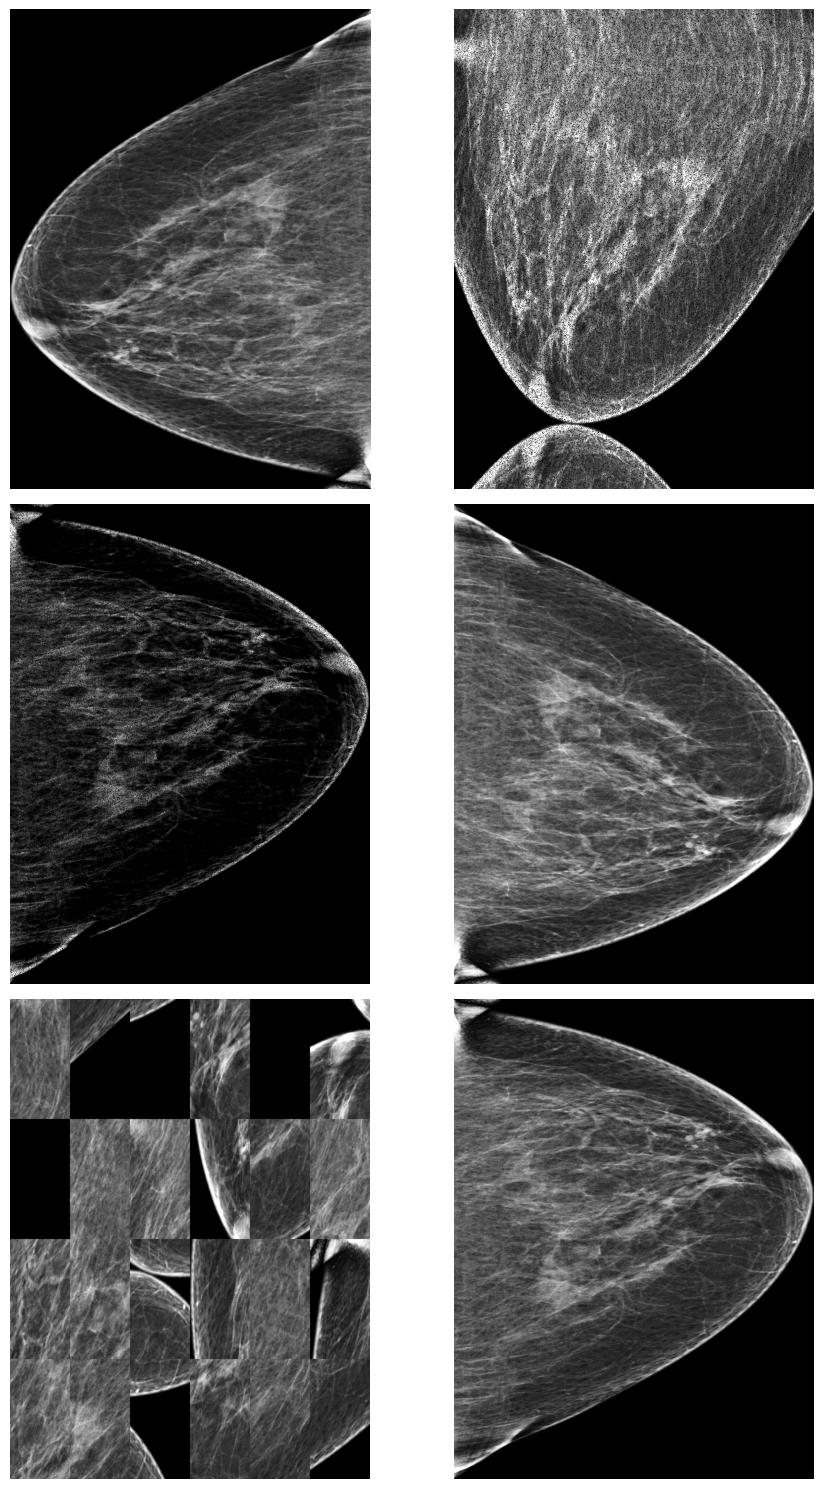

In [21]:
def show_augmentation(transform: A,
                      image: str) -> None:
    rows = 3
    cols = 2
    
    img_orig = Image.open(image)
    img_orig = np.array(img_orig)
    img_transformed = transform(image=img_orig)['image']

    fig = plt.figure(figsize=(10,15))
    fig.add_subplot(rows, cols, 1)
    plt.imshow(img_orig, cmap='gray')
    plt.axis(False)
    
    for i in range(2, cols* rows +1):
        fig.add_subplot(rows, cols, i)
        plt.imshow(transform(image=img_orig)['image'], cmap='gray')
        plt.axis(False)
    plt.tight_layout()
    
show_augmentation(transform, '../png/train_images/0/1025/347069540.png')

Now, let's augment and see what we've got. We only augment train split.

In [15]:
def augment_images(image: str,
                   dir_dest: str) -> None:
        
    class_label, id_patient, id_img = re.findall('(\d+)',image)
        
    img_orig = Image.open(image)
    img_orig = np.array(img_orig)

    path_save = os.path.join(dir_dest, class_label, id_patient)
    os.makedirs(path_save, exist_ok=True)
    
    if int(class_label): #if cancer: make 3 augmented copies
        for i in range(3): 
            img_transformed = transform(image=img_orig)['image']
            cv2.imwrite(f'{path_save}/{id_img}_augmented_{i}.png', img_transformed)
    else:
        img_transformed = transform(image=img_orig)['image']
        cv2.imwrite(f'{path_save}/{id_img}_augmented_1.png', img_transformed)
            

In [16]:
train_images = glob.glob(path_train_png + '/*/*/*.png')
for image in tqdm(train_images):
    augment_images(image, path_train_png)

100%|█████████████████████████████████████| 43764/43764 [14:34<00:00, 50.06it/s]


## Divide images by class<a id='class_separation'></a>
[back to table of content](#toc)

In [17]:
def images_to_heap(dir_source: str,
                   dir_save: str) -> None:
    
    images = glob.glob(dir_source + '/*/*/*.png')
    class_labels = set()
    for image in tqdm(images):
        
        class_label, id_patient= re.findall('(\d+)', image)[:2]
        class_labels.add(class_label)
        
        img_name = os.path.basename(image)
        file_name_new = f'{id_patient}_{img_name}'
        shutil.move(image, os.path.join(dir_save, class_label, file_name_new))
        
    #Remove empty folders
    for label in class_labels:        
        path_clean_up = f'{dir_source}/{label}'
        for folder in os.listdir(path_clean_up): 
            try:
                os.removedirs(os.path.join(path_clean_up, folder))
            except:
                pass

In [18]:
images_to_heap(path_train_png, path_train_png)

100%|██████████████████████████████████| 89380/89380 [00:02<00:00, 41073.64it/s]


In [19]:
images_to_heap(path_test_png, path_test_png)

100%|██████████████████████████████████| 10942/10942 [00:00<00:00, 39233.85it/s]


Now we have two folders: `train_images` and `test_images`<img src='images/folders.png'> , each containing two subfolders with images of classes respective to their folder names<img src='images/subfolders.png'>.

### Uploading data to Google Drive.<a id='upload'></a>
[back to table of content](#toc)

You may skip this part, as it is not crucial for the project's results. 

I created a web application in Google Workspace, obtained an authentication key, and tested whether I could view files on my Google Drive. The code used is not mine; it is an example from Google API documentation.

In [ ]:
import os.path

from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaFileUpload

# If modifying these scopes, delete the file token.json.
SCOPES = ["https://www.googleapis.com/auth/drive"]


def main():
  """
  Prints the names and ids of the first 10 files the user has access to.
  """
  creds = None
  # The file token.json stores the user's access and refresh tokens, and is
  # created automatically when the authorization flow completes for the first
  # time.
  if os.path.exists("token.json"):
    creds = Credentials.from_authorized_user_file("token.json", SCOPES)
  # If there are no (valid) credentials available, let the user log in.
  if not creds or not creds.valid:
    if creds and creds.expired and creds.refresh_token:
      creds.refresh(Request())
    else:
      flow = InstalledAppFlow.from_client_secrets_file(
          "credentials.json", SCOPES
      )
      creds = flow.run_local_server(port=8080)
    # Save the credentials for the next run
    with open("token.json", "w") as token:
      token.write(creds.to_json())

  try:
    service = build("drive", "v3", credentials=creds)

    # Call the Drive v3 API
    results = (
        service.files()
        .list(pageSize=10, fields="nextPageToken, files(id, name)")
        .execute()
    )
    items = results.get("files", [])

    if not items:
      print("No files found.")
      return
    print("Files:")
    for item in items:
      print(f"{item['name']} ({item['id']})")
  except HttpError as error:
    # TODO(developer) - Handle errors from drive API.
    print(f"An error occurred: {error}")

main()

I now upload files to my Google Drive, uploading the train and test folders separately and manually. I've completed this process in another kernel, so I won't execute it here. The only result visible would be the progress bar anyway.

In [ ]:
service = build("drive", "v3", credentials=creds)
folder_id = '1hKB0SB5SPewBoYR3Lx7GSSLqjSej0vfW' # this is folder id on my Google Drive.
file_names = glob.glob('../png/train_images/1/*.png')
mime_type = 'image/png'

for file in tqdm(file_names): 
    file_metadata = {
        'name': file,
        'parents': [folder_id],
    }
    
    media = MediaFileUpload(file, mime_type)

    service.files().create(
        body=file_metadata,
        media_body=media,
        fields='id').execute()

## Torch block<a id='torch'></a>
[back to table of content](#toc)

In [ ]:
# ML imports
import torch
import torchvision
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.datasets import ImageFolder
from torcheval.metrics.functional import binary_confusion_matrix 

device = 'cuda' if torch.cuda.is_available() else 'cpu'

* `precision`, `recall`, `accuracy`, `f_score`, `create_dataloader` and `freeze_model` are self-explanatory: those are custom metrics functions and functions for creating dataloaders and freezing hidden layers of a pretrained model.
* `train_step` may can be used as validation step if "validation" parameter is set to True. It returns step loss and binary confusion matrix that is later used for calculating metrics.
* `create_writer` creates SummaryWriter used by tensorboard. We will use the path to the writer for experiment tracking. Most likely, you will not see this, but I will use it a lot behind the scenes.
* `train_model` will perform train and validation steps for n epochs and return dictionary with metrics for each one. Although we will use TensorBoard and there is no need for this dictionary, I think it may be useful in my later projects if I won't use TensorBoard. This function will also print out some information about the training process so we won't be left wondering if it is working at all.

In [ ]:
# metrics 

# tp = cm[1][1] 
# fp = cm[0][1] 
# fn = cm[1][0]
# tn = cm[0][0]

def precision(cm:np.ndarray) -> float:
    tp = cm[1][1] 
    fp = cm[0][1]
    return tp / (tp + fp)

def recall(cm:np.ndarray) -> float:
    tp = cm[1][1] 
    fn = cm[1][0]
    return tp / (tp + fn)

def accuracy(cm:np.ndarray) -> float:
    tp = cm[1][1]
    tn = cm[0][0]
    return (tp + tn) / cm.sum()

def f_score(cm:np.ndarray, factor: int=1) -> float:
    tp = cm[1][1]
    fp = cm[0][1]
    fn = cm[1][0]
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_score = (1 + factor ** 2) * ((precision * recall) / (factor * precision + recall))
    return f_score

# torch workflow
def create_dataloader(dataset:str,
                      batch_size: int=16,
                      pin_memory: bool=True,
                      shuffle: bool=True) -> torch.utils.data.DataLoader:

    loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        pin_memory=pin_memory
    )    
    
    return loader   

def train_step(model: nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: nn.Module,
              optimizer: torch.optim.Optimizer,
              device: str,
              validation: bool=False) -> float:
    loss = 0
    if not validation:
        
        model.train()
        
        for X, y in loader:
            
            X, y = X.to(device), y.loat().to(device)
    
            logits = model(X)#.squeeze()
            preds = logits.sigmoid().round()
    
            loss_batch = loss_fn(logits, y)
            loss += loss_batch.item()
            cm = binary_confusion_matrix(preds, y.long()).detach().cpu().numpy()
            
            optimizer.zero_grad()
            loss_batch.backward()
            optimizer.step()
        
    if validation:
        
        model.eval()
        with torch.inference_mode():

            for X, y in loader:
                
            X, y = X.to(device), y.float().to(device)

            logits = model(X)#.squeeze()
            preds = logints.sigmoid().round()

            loss_batch = loss_fn(logits, y)
            loss += loss_batch
            cm = binary_confusion_matrix(preds, y.long()).detach().cpu().numpy()

            
    return loss, cm

def freeze_model(model):
    for param in model.parameters():
    param.requires_grad = False

def create_writer(experiment_name: str,
                  model_name: str,
                  extra: str=None) -> torch.utils.tensorboard.SummaryWriter():
    from datetime import datetime
    import os

    timestamp = datetime.now().strftime('%Y-%m-%d')

    if extra:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)

    print(f'Created Summary Writer. Saved to {log_dir}.')

    return SummaryWriter(log_dir=log_dir)

def train_model(model: nn.Module,
                optimizer: torch.optim.Optimizer,
                loss_fn: nn.Module,
                loader_train: torch.utils.data.DataLoader,
                loader_test: torch.utils.data.DataLoader,
                writer: torch.utils.tensorboard.SummaryWriter(),
                device: str,
                n_epochs: int=11,
                ) -> dict:
  # Statistics to track.
    results = {'loss_train': [],
               'precision_train': [],
               'recall_train': [],
               'f_score_train': [],
               'loss_test': [],
               'precision_test': [],
               'recall_test': [],
               'f_score_test': [],
               }
    cm_train_total = 0
    cm_test_total = 0
    for epoch in range(n_epochs):

        print(f'Epoch #{epoch}')

        #train and test steps
        loss_train, cm_train = train_step(model, loader_train, loss_fn, optimizer, device)
        loss_test, cm_test = train_step(model, loader_test, loss_fn, optimizer, device)
        cm_train_total += cm_train
        cm_test_total += cm_test
        # Update statistics in case we will need them later.
        results['loss_train'].append(loss_train)
        results['precision_train'].append(precision(cm_train))
        results['recall_train'].append(recall(cm_train))
        results['f_score_train'].append(f_score(cm_train))
        results['loss_test'].append(loss_test)
        results['precision_test'].append(precision(cm_test))
        results['recall_test'].append(recall(cm_test))
        results['f_score_test'].append(f_score(cm_test))

      # Update statistics for tensorboard.
    if writer:
        writer.add_scalars(main_tag='Loss',
                          tag_scalar_dict={'loss_train': loss_train,
                                            'loss_test': loss_test,},
                          global_step=epoch)
        
        writer.add_scalars(main_tag='Precision',
                          tag_scalar_dict={'precision_train': results['precision_train'][-1],
                                            'precision_test': results['precision_test'][-1]},
                          global_step=epoch)
        
        writer.add_scalars(main_tag='Recall',
                          tag_scalar_dict={'recall_train': results['recall_train'][-1],
                                        'recall_test': results['recall_test'][-1]},
                          global_step=epoch)
        
        writer.add_scalars(main_tag='F-score',
                          tag_scalar_dict={'f_score_train': results['f_score_train'][-1],
                                        'f_score_test': results['f_score_test'][-1]},
                          global_step=epoch)
        
      if epoch % 5 == 0:
          print(f"Train loss: [{loss_train}] Train precision: [{results['precision_train'][-1]}] Train recall: [{results['recall_train'][-1]}] Train F-score: [{results['f_score_train'][-1]}]\n"\
                f"Test loss: [{loss_test}] Test precision[{results['precision_test'][-1]}] Test recall[{results['recall_test'][-1]}] Test F-score: [{results['f_score_test'][-1]}]")
          
  writer.close()
  return results, cm_train_total, cm_test_total

In [ ]:
# Download model and weights
weights = ResNet18_Weights.DEFAULT
transforms_auto = weights.transforms()

In [ ]:
# Data initialization.
path_train = '../train_images'
path_test = '../test_images'

dataset_train = ImageFolder(path_train, transform=transforms_auto)
dataset_test = ImageFolder(path_test, transform=transforms_auto)

loader_train = create_dataloader(dataset_train)
loader_test = create_dataloader(dataset_test, shuffle=False)

In [ ]:
# Model parameters.
model = resnet18(weights=weights)
freeze_model(model)
model.fc = nn.Linear(in_features=512, out_features=1, bias=True)
model.to(device)

writer = create_writer('TestingOutFunctions',model.__class__.__name__)
lr = 3e-4
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
loss_fn = nn.BCEWithLogitsLoss()

In [ ]:
results, cm_train, cm_test = train_model(model=model,
                                         optimizer=optimizer,
                                         loss_fn=loss_fn,
                                         loader_train=loader_train,
                                         loader_test=loader_test,
                                         device=device,
                                         writer=writer,
                                         n_epochs=11)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs